/home/juliantearney/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<photutils.segmentation.core.SegmentationImage>
shape: (75, 75)
nlabels: 3
labels: [1 2 3]


Text(0.5, 1.0, 'Segmentation Image')

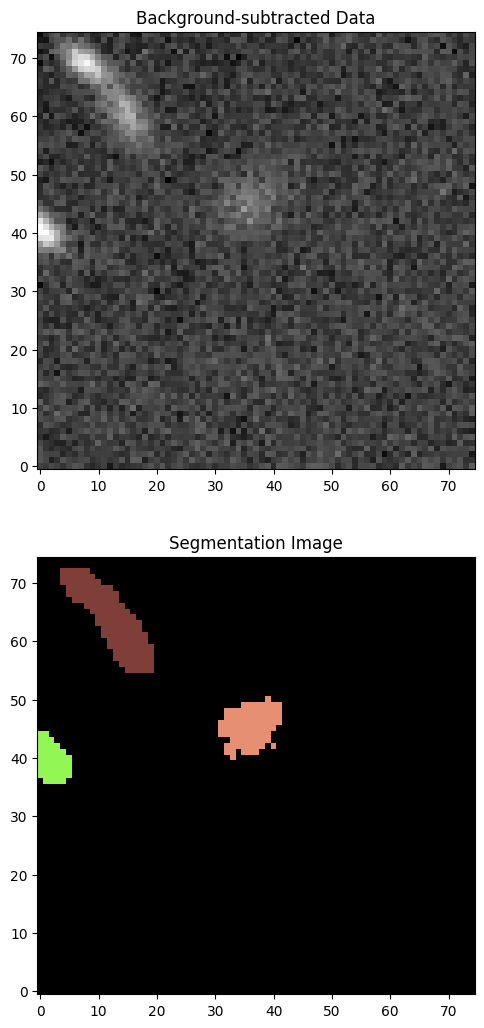

In [1]:
from astropy.convolution import convolve
import photutils
from photutils.datasets import make_100gaussians_image
from photutils.segmentation import detect_sources
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

data = make_100gaussians_image()[:75,:75]
from photutils.segmentation import make_2dgaussian_kernel

from photutils.background import Background2D, SExtractorBackground
bkg_estimator = SExtractorBackground()
bkg = Background2D(data, (8, 8), filter_size=(5, 5),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

kernel = make_2dgaussian_kernel(3, size=3)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

segment_map = detect_sources(convolved_data, threshold=1.5* bkg.background_rms, npixels=10)
print(segment_map)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r')
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

In [2]:
segment_map.nlabels

3

In [3]:
seg_mask =  (segment_map.data == 1) + (segment_map.data == 2) + (segment_map.data == 3)

masked_data = np.ma.array(data=data, mask=seg_mask)

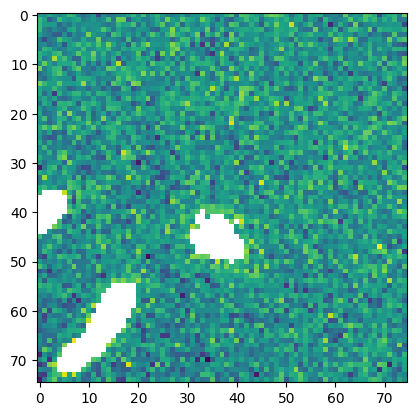

In [4]:
plt.imshow(masked_data)

In [5]:
std = np.std(masked_data)
mean = np.mean(masked_data)

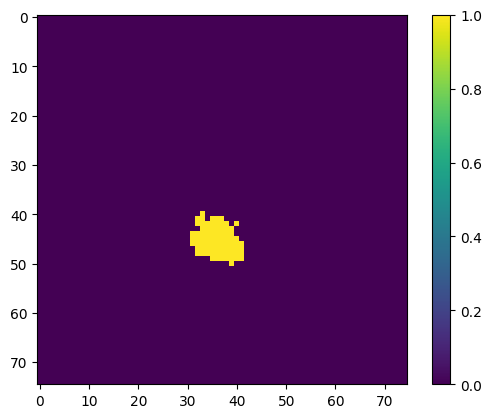

In [6]:
plt.imshow((segment_map.data == 2))
plt.colorbar()

In [8]:
gal_mask = ~(segment_map.data == 2)
print(gal_mask.shape)
print(data.shape)

(75, 75)
(75, 75)


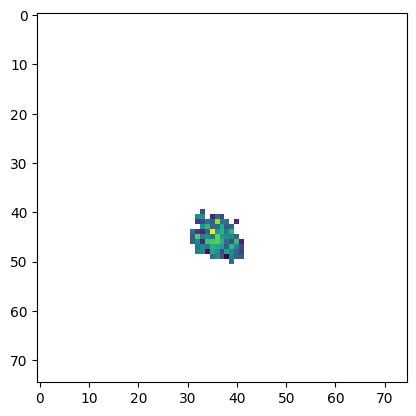

In [9]:
flux_galaxy = np.ma.array(data=data, mask=gal_mask)
plt.imshow(flux_galaxy)

In [10]:
noise = np.random.normal(loc=mean, scale=std, size=masked_data.shape)

seg_mask =  (segment_map.data == 1) + (segment_map.data == 2) + (segment_map.data == 3)

filled_data = np.copy(data)

filled_data[seg_mask] = noise[seg_mask]

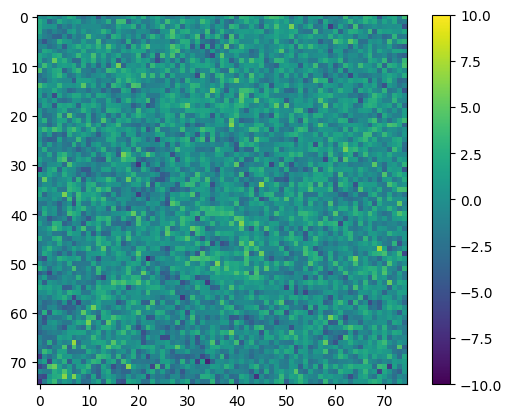

In [11]:
plt.imshow(filled_data, vmin=-10, vmax=10)
plt.colorbar()

In [13]:
indices = np.argwhere(gal_mask==False)
print(indices.shape)
dummy = np.copy(filled_data)
dummy[indices] = flux_galaxy[indices]

(79, 2)


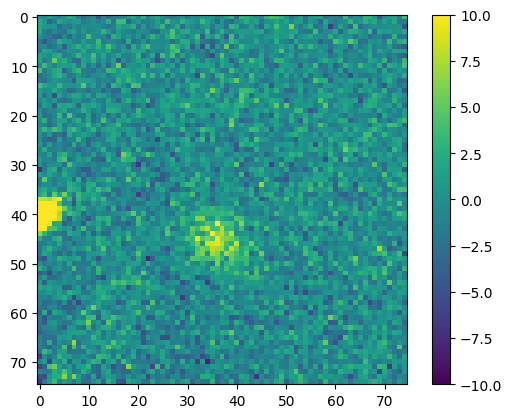

In [14]:
plt.imshow(dummy, vmin=-10, vmax=10 )
plt.colorbar()